# Introduction

We tackle the problem of OCR post processing. In OCR, we map the image form of the document into the text domain. This is done first using an CNN+LSTM+CTC model, in our case based on tesseract. Since this output maps only image to text, we need something on top to validate and correct language semantics.

The idea is to build a language model, that takes the OCRed text and corrects it based on language knowledge. The langauge model could be:
- Char level: the aim is to capture the word morphology. In which case it's like a spelling correction system.
- Word level: the aim is to capture the sentence semnatics. But such systems suffer from the OOV problem.
- Fusion: to capture semantics and morphology language rules. The output has to be at char level, to avoid the OOV. However, the input can be char, word or both.

The fusion model target is to learn:

    p(char | char_context, word_context)

In this workbook we use seq2seq vanilla Keras implementation, adapted from the lstm_seq2seq example on Eng-Fra translation task. The adaptation involves:

- Adapt to spelling correction, on char level
- Pre-train on a noisy, medical sentences
- Fine tune a residual, to correct the mistakes of tesseract 
- Limit the input and output sequence lengths
- Enusre teacher forcing auto regressive model in the decoder
- Limit the padding per batch
- Learning rate schedule
- Bi-directional LSTM Encoder
- Bi-directional GRU Encoder


# Imports

In [1]:
from __future__ import print_function
import tensorflow as tf
import keras.backend as K
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Bidirectional, Concatenate, GRU
from keras import optimizers
from keras.callbacks import ModelCheckpoint, TensorBoard, LearningRateScheduler
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


# Utility functions

In [2]:
# Limit gpu allocation. allow_growth, or gpu_fraction
def gpu_alloc():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    set_session(tf.Session(config=config))

In [3]:
gpu_alloc()

In [4]:
def calculate_WER_sent(gt, pred):
    '''
    calculate_WER('calculating wer between two sentences', 'calculate wer between two sentences')
    '''
    gt_words = gt.lower().split(' ')
    pred_words = pred.lower().split(' ')
    d = np.zeros(((len(gt_words) + 1), (len(pred_words) + 1)), dtype=np.uint8)
    # d = d.reshape((len(gt_words)+1, len(pred_words)+1))

    # Initializing error matrix
    for i in range(len(gt_words) + 1):
        for j in range(len(pred_words) + 1):
            if i == 0:
                d[0][j] = j
            elif j == 0:
                d[i][0] = i

    # computation
    for i in range(1, len(gt_words) + 1):
        for j in range(1, len(pred_words) + 1):
            if gt_words[i - 1] == pred_words[j - 1]:
                d[i][j] = d[i - 1][j - 1]
            else:
                substitution = d[i - 1][j - 1] + 1
                insertion = d[i][j - 1] + 1
                deletion = d[i - 1][j] + 1
                d[i][j] = min(substitution, insertion, deletion)
    return d[len(gt_words)][len(pred_words)]

In [5]:
def calculate_WER(gt, pred):
    '''

    :param gt: list of sentences of the ground truth
    :param pred: list of sentences of the predictions
    both lists must have the same length
    :return: accumulated WER
    '''
#    assert len(gt) == len(pred)
    WER = 0
    nb_w = 0
    for i in range(len(gt)):
        #print(gt[i])
        #print(pred[i])
        WER += calculate_WER_sent(gt[i], pred[i])
        nb_w += len(gt[i])

    return WER / nb_w

In [6]:
# Artificial noisy spelling mistakes
def noise_maker(sentence, threshold):
    '''Relocate, remove, or add characters to create spelling mistakes'''
    letters = ['a','b','c','d','e','f','g','h','i','j','k','l','m',
           'n','o','p','q','r','s','t','u','v','w','x','y','z',]
    noisy_sentence = []
    i = 0
    while i < len(sentence):
        random = np.random.uniform(0, 1, 1)
        # Most characters will be correct since the threshold value is high
        if random < threshold:
            noisy_sentence.append(sentence[i])
        else:
            new_random = np.random.uniform(0, 1, 1)
            # ~33% chance characters will swap locations
            if new_random > 0.67:
                if i == (len(sentence) - 1):
                    # If last character in sentence, it will not be typed
                    continue
                else:
                    # if any other character, swap order with following character
                    noisy_sentence.append(sentence[i + 1])
                    noisy_sentence.append(sentence[i])
                    i += 1
            # ~33% chance an extra lower case letter will be added to the sentence
            elif new_random < 0.33:
                random_letter = np.random.choice(letters, 1)[0]
                noisy_sentence.append(random_letter)
                noisy_sentence.append(sentence[i])
            # ~33% chance a character will not be typed
            else:
                pass
        i += 1

    return ''.join(noisy_sentence)

In [7]:
def load_data_with_gt(file_name, num_samples, max_sent_len, min_sent_len):
    '''Load data from txt file, with each line has: <TXT><TAB><GT>. The  target to the decoder muxt have \t as the start trigger and \n as the stop trigger.'''
    cnt = 0  
    input_texts = []
    gt_texts = []
    target_texts = []
    #for row in open(file_name, encoding='utf8'):
    for row in open(file_name):
        if cnt < num_samples :
            #print(row)
            sents = row.split("\t")
            input_text = sents[0]
            
            target_text = '\t' + sents[1] + '\n'
            if len(input_text) > min_sent_len and len(input_text) < max_sent_len and len(target_text) > min_sent_len and len(target_text) < max_sent_len:
                cnt += 1
                
                input_texts.append(input_text)
                target_texts.append(target_text)
                gt_texts.append(sents[1])
    return input_texts, target_texts, gt_texts

In [8]:
def load_data_with_noise(file_name, num_samples, noise_threshold, max_sent_len, min_sent_len):
    '''Load data from txt file, with each line has: <TXT>. The GT is just a noisy version of TXT. The  target to the decoder muxt have \t as the start trigger and \n as the stop trigger.'''
    cnt = 0  
    input_texts = []
    gt_texts = []
    target_texts = []
    while cnt < num_samples :
        #for row in open(file_name, encoding='utf8'):
        for row in open(file_name):
            if cnt < num_samples :
                sents = row.split("\t")
                input_text = noise_maker(sents[1], noise_threshold)
                input_text = input_text[:-1]

                target_text = '\t' + sents[1] + '\n'            
                if len(input_text) > min_sent_len and len(input_text) < max_sent_len and len(target_text) > min_sent_len and len(target_text) < max_sent_len:
                    cnt += 1
                    input_texts.append(input_text)
                    target_texts.append(target_text)
                    gt_texts.append(target_text[1:-1])
                    
    return input_texts, target_texts, gt_texts

In [9]:
def build_vocab(all_texts):
    '''Build vocab dictionary to victorize chars into ints'''
    vocab_to_int = {}
    count = 0
    
    for sentence in all_texts:
        for char in sentence:
            if char not in vocab_to_int:
                vocab_to_int[char] = count
                count += 1
    # Add special tokens to vocab_to_int
    codes = ['\t','\n']
    for code in codes:
        if code not in vocab_to_int:
            vocab_to_int[code] = count
            count += 1
    '''''Build inverse translation from int to char'''
    int_to_vocab = {}
    for character, value in vocab_to_int.items():
        int_to_vocab[value] = character
        
    return vocab_to_int, int_to_vocab

In [10]:
def vectorize_data(input_texts, target_texts, max_encoder_seq_length, num_encoder_tokens, vocab_to_int):
    '''Prepares the input text and targets into the proper seq2seq numpy arrays'''
    encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
    decoder_input_data = np.zeros(
        (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
        dtype='float32')
    decoder_target_data = np.zeros(
        (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
        dtype='float32')

    for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
        for t, char in enumerate(input_text):
            # c0..cn
            encoder_input_data[i, t, vocab_to_int[char]] = 1.
        for t, char in enumerate(target_text):
            # c0'..cm'
            # decoder_target_data is ahead of decoder_input_data by one timestep
            decoder_input_data[i, t, vocab_to_int[char]] = 1.
            if t > 0:
                # decoder_target_data will be ahead by one timestep
                # and will not include the start character.
                decoder_target_data[i, t - 1, vocab_to_int[char]] = 1.
                
    return encoder_input_data, decoder_input_data, decoder_target_data

In [11]:
def decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, vocab_to_int['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = int_to_vocab[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


# Load data

In [12]:
data_path = '../../dat/'

In [13]:
max_sent_len = 1000000
min_sent_len = -1

## Results on tesseract correction

In [14]:
num_samples = 1000000
tess_correction_data = os.path.join(data_path, 'all_ocr_data_2.txt')
input_texts_OCR, target_texts_OCR, gt_OCR = load_data_with_gt(tess_correction_data, num_samples, max_sent_len, min_sent_len)

In [15]:
input_texts = input_texts_OCR
target_texts = target_texts_OCR

In [16]:
## Histogram of lenghts
lengths = []
for text in input_texts:
    lengths.append(len(text))
    lengths.append(len(text))

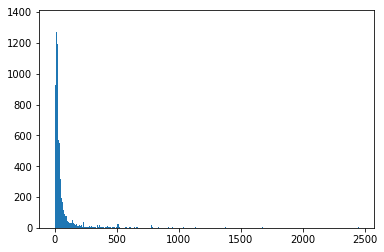

In [17]:
h = plt.hist(lengths, bins=500)

In [18]:
h[0]

array([ 1174.,   926.,  1344.,  1268.,  1192.,   768.,   568.,   548.,
         404.,   318.,   172.,   194.,   166.,   228.,   116.,   148.,
          88.,    76.,    74.,    78.,    74.,    42.,    38.,    32.,
          32.,    26.,    30.,    30.,    50.,    50.,    30.,     8.,
          24.,    26.,    20.,    22.,    12.,    14.,    22.,    12.,
          18.,    22.,    10.,    28.,    16.,     4.,    14.,    40.,
           2.,     6.,     6.,     0.,     6.,     2.,    34.,     4.,
           0.,    12.,     6.,     6.,    10.,    14.,     6.,     2.,
           4.,     2.,     6.,     2.,     0.,     2.,    16.,    12.,
           8.,    16.,     2.,     2.,     4.,     4.,     2.,     0.,
           2.,     0.,     2.,     6.,     2.,     4.,    10.,    28.,
           4.,     2.,     4.,     4.,     2.,     0.,     4.,     4.,
           6.,     0.,     4.,     0.,     4.,     4.,     2.,    22.,
          22.,     2.,     2.,     0.,     0.,     0.,     2.,     0.,
      

In [19]:
h[1]

array([    0.   ,     4.906,     9.812,    14.718,    19.624,    24.53 ,
          29.436,    34.342,    39.248,    44.154,    49.06 ,    53.966,
          58.872,    63.778,    68.684,    73.59 ,    78.496,    83.402,
          88.308,    93.214,    98.12 ,   103.026,   107.932,   112.838,
         117.744,   122.65 ,   127.556,   132.462,   137.368,   142.274,
         147.18 ,   152.086,   156.992,   161.898,   166.804,   171.71 ,
         176.616,   181.522,   186.428,   191.334,   196.24 ,   201.146,
         206.052,   210.958,   215.864,   220.77 ,   225.676,   230.582,
         235.488,   240.394,   245.3  ,   250.206,   255.112,   260.018,
         264.924,   269.83 ,   274.736,   279.642,   284.548,   289.454,
         294.36 ,   299.266,   304.172,   309.078,   313.984,   318.89 ,
         323.796,   328.702,   333.608,   338.514,   343.42 ,   348.326,
         353.232,   358.138,   363.044,   367.95 ,   372.856,   377.762,
         382.668,   387.574,   392.48 ,   397.386, 

In [20]:
max_sent_len =  h[1][np.argmax(h[0])]
min_sent_len = h[1][1]
print('Most probable length = ', max_sent_len)
print('Count of most probable lenght = ', np.max(h[0]))
print('Min length = ', min_sent_len)

Most probable length =  9.812
Count of most probable lenght =  1344.0
Min length =  4.906


In [21]:
max_sent_len =  100#int(np.ceil(max_sent_len))
min_sent_len = 4#int(np.floor(min_sent_len))

In [22]:
print('Most probable length = ', max_sent_len)
print('Min length = ', min_sent_len)

Most probable length =  100
Min length =  4


In [23]:
num_samples = 1000000
tess_correction_data = os.path.join(data_path, 'all_ocr_data_2.txt')
input_texts_OCR, target_texts_OCR, gt_OCR = load_data_with_gt(tess_correction_data, num_samples, max_sent_len, min_sent_len)

In [24]:
input_texts = input_texts_OCR
target_texts = target_texts_OCR

In [25]:
len(input_texts)

4313

# Results of pre-training on generic data

In [26]:
'''
num_samples = 0
big_data = os.path.join(data_path, 'big.txt')
threshold = 0.9
input_texts_gen, target_texts_gen, gt_gen = load_data_with_noise(file_name=big_data, 
                                                                 num_samples=num_samples, 
                                                                 noise_threshold=threshold, 
                                                                 max_sent_len=max_sent_len, 
                                                                 min_sent_len=min_sent_len)
'''                                                                 

"\nnum_samples = 0\nbig_data = os.path.join(data_path, 'big.txt')\nthreshold = 0.9\ninput_texts_gen, target_texts_gen, gt_gen = load_data_with_noise(file_name=big_data, \n                                                                 num_samples=num_samples, \n                                                                 noise_threshold=threshold, \n                                                                 max_sent_len=max_sent_len, \n                                                                 min_sent_len=min_sent_len)\n"

In [27]:
#input_texts = input_texs_gen
#target_texts = target_texts_gen

# Results on noisy tesseract corrections

In [28]:
num_samples = 10000
tess_correction_data = os.path.join(data_path, 'all_ocr_data_2.txt')
threshold = 0.9
input_texts_noisy_OCR, target_texts_noisy_OCR, gt_noisy_OCR = load_data_with_noise(file_name=tess_correction_data, 
                                                                 num_samples=num_samples, 
                                                                 noise_threshold=threshold, 
                                                                 max_sent_len=max_sent_len, 
                                                                 min_sent_len=min_sent_len)

In [29]:
'''
input_texts = input_texts_noisy_OCR
target_texts = target_texts_noisy_OCR
'''

'\ninput_texts = input_texts_noisy_OCR\ntarget_texts = target_texts_noisy_OCR\n'

# Results on merge of tesseract correction + generic data

In [30]:
'''
input_texts = input_texts_OCR + input_texts_gen
target_texts = input_texts_OCR + target_texts_gen
'''

'\ninput_texts = input_texts_OCR + input_texts_gen\ntarget_texts = input_texts_OCR + target_texts_gen\n'

# Results noisy tesseract correction + generic data

In [31]:
'''
input_texts = input_texts_noisy_OCR + input_texts_gen
target_texts = input_texts_noisy_OCR + target_texts_gen
'''

'\ninput_texts = input_texts_noisy_OCR + input_texts_gen\ntarget_texts = input_texts_noisy_OCR + target_texts_gen\n'

# Results noisy tesseract noisy + correction data

In [32]:
input_texts = input_texts_noisy_OCR + input_texts_OCR
target_texts = target_texts_noisy_OCR + target_texts_OCR

# Results of pre-training on generic and fine tuning on tesseract correction

In [33]:
# TODO

In [34]:
# Sample data
print(len(input_texts))
for i in range(10):
    print(input_texts[i], '\n', target_texts[i])

14313
Clim Type: VB Accident - Accidentl Injury 
 	Claim Type: VB Accident - Accidental Injury


Who vThe Reported Event Hapened o:EmployeeP/olicyhcolder 
 	Who The Reported Event Happened To: Employee/Policyholder


Policyolder/Owner Information 
 	Policyholder/Owner Information


Fisrt Name:r 
 	First Name:


Middle NameI/nitial: 
 	Middle Name/Initial:


Last Naem: 
 	Last Name:


Social Securit Nmber: 
 	Social Security Number:


Brirth Date: 
 	Birth Date:


Gender:t 
 	Gender:


Lanugage Preferece: 
 	Language Preference:




## Build vocab

In [35]:
all_texts = target_texts + input_texts
vocab_to_int, int_to_vocab = build_vocab(all_texts)
np.savez('vocab', vocab_to_int=vocab_to_int, int_to_vocab=int_to_vocab, max_sent_len=max_sent_len, min_sent_len=min_sent_len )

In [36]:
input_characters = sorted(list(vocab_to_int))
target_characters = sorted(list(vocab_to_int))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [37]:
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 14313
Number of unique input tokens: 121
Number of unique output tokens: 121
Max sequence length for inputs: 99
Max sequence length for outputs: 99


# Prepare training data

## Train/test split

In [38]:
# Split the data into training and testing sentences
input_texts, test_input_texts, target_texts, test_target_texts  = train_test_split(input_texts, target_texts, test_size = 0.15, random_state = 42)

## Vectorize data

## Train data

In [39]:
encoder_input_data, decoder_input_data, decoder_target_data = vectorize_data(input_texts=input_texts,
                                                                             target_texts=target_texts, 
                                                                             max_encoder_seq_length=max_encoder_seq_length, 
                                                                             num_encoder_tokens=num_encoder_tokens, 
                                                                             vocab_to_int=vocab_to_int)

## Test data

In [40]:
test_encoder_input_data, test_decoder_input_data, test_decoder_target_data = vectorize_data(input_texts=test_input_texts,
                                                                                            target_texts=test_target_texts, 
                                                                                            max_encoder_seq_length=max_encoder_seq_length, 
                                                                                            num_encoder_tokens=num_encoder_tokens, 
                                                                                            vocab_to_int=vocab_to_int)

# Training model

In [41]:
batch_size = 64  # Batch size for training.
epochs = 200  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
lr = 0.01

In [47]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
# TODO: Add Embedding for chars
encoder = LSTM(latent_dim, return_state=True)
#encoder = Bidirectional(LSTM(latent_dim, return_state=True))
#encoder = Bidirectional(GRU(latent_dim, return_state=True))
#encoder = GRU(latent_dim, return_state=True)

encoder_outputs, state_h, state_c = encoder(encoder_inputs)
#encoder_outputs, state_f_h, state_f_c, state_b_h, state_b_c = encoder(encoder_inputs)
#encoder_outputs, state_f, state_b = encoder(encoder_inputs)

#state = Concatenate()([state_f, state_b])
#state_h = Concatenate()([state_f_h, state_b_h])
#state_c = Concatenate()([state_f_c, state_b_c])

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]
#encoder_states = [state]
#encoder_states = [state_f_h, state_f_c, state_b_h, state_b_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
#decoder_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True)
#decoder_lstm = GRU(latent_dim*2, return_sequences=True, return_state=True)
'''
decoder_outputs, _, _ = Bidirectional(decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states))
'''

decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)


#decoder_outputs, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, None, 121)    0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, None, 121)    0                                            
__________________________________________________________________________________________________
lstm_7 (LSTM)                   [(None, 256), (None, 387072      input_7[0][0]                    
__________________________________________________________________________________________________
lstm_8 (LSTM)                   [(None, None, 256),  387072      input_8[0][0]                    
                                                                 lstm_7[0][1]                     
          

# Learning rate decay

In [48]:
model.compile(optimizer=optimizers.Adam(lr=lr), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [49]:
#filepath="weights-improvement-{epoch:02d}-{val_categorical_accuracy:.2f}.hdf5"
filepath="best_model.hdf5" # Save only the best model for inference step, as saving the epoch and metric might confuse the inference function which model to use
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
callbacks_list = [checkpoint, tbCallBack]
#callbacks_list = [checkpoint, tbCallBack, lrate]



In [ ]:
def exp_decay(epoch):
    initial_lrate = 0.1
    k = 0.1
    lrate = initial_lrate * np.exp(-k*epoch)
    return lrate
lrate = LearningRateScheduler(exp_decay)
#lr = 0

In [ ]:
def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate
lrate = LearningRateScheduler(step_decay)
#lr = 0

In [ ]:
#callbacks_list.append(lrate)

In [50]:
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          validation_data = ([test_encoder_input_data, test_decoder_input_data], test_decoder_target_data),
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks_list,
          #validation_split=0.2,
          shuffle=True)

Train on 12166 samples, validate on 2147 samples
Epoch 1/200
12166/12166 [==============================] - 59s 5ms/step - loss: 0.7763 - categorical_accuracy: 0.0986 - val_loss: 0.5591 - val_categorical_accuracy: 0.1477
Epoch 2/200


/root/anaconda2/lib/python2.7/site-packages/keras/engine/topology.py:2344: UserWarning: Layer lstm_8 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_7/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_7/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


 3328/12166 [=======>......................] - ETA: 40s - loss: 0.5269 - categorical_accuracy: 0.1600

KeyboardInterrupt: 

# Inference model

In [51]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
#decoder_state_input_h = Input(shape=(latent_dim*2,))
#decoder_state_input_c = Input(shape=(latent_dim*2,))
#decoder_state_input = Input(shape=(latent_dim*2,))

decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
#decoder_states_inputs = [decoder_state_input]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)

#decoder_outputs, state = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)

decoder_states = [state_h, state_c]
#decoder_states = [state]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [53]:
encoder_model.save('encoder_model.hdf5')
decoder_model.save('decoder_model.hdf5')

/root/anaconda2/lib/python2.7/site-packages/keras/engine/topology.py:2344: UserWarning: Layer lstm_8 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'input_9:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'input_10:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


In [52]:
# Sample output from train data
decoded_sentences = []
target_texts_ =  []
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.

    input_seq = encoder_input_data[seq_index: seq_index + 1]
    
    decoded_sentence = decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab)
    target_text = target_texts[seq_index][1:-1]
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)   
    decoded_sentences.append(decoded_sentence)
    target_texts_.append(target_text)

-
Input sentence: DOcB

GT sentence: DOB:

Decoded sentence: PATE NT SERERE CORTENT PATIENT PATE NT STOREST PATE NT STOREST PATE NT STOREST PATE NT STOREST PATE 
-
Input sentence: 2. Noawemamliy harmed
GT sentence: 2. No acute osseous abnormality identified.

Decoded sentence: Employee Patient Name:

-
Input sentence: Physicin Name (as Name, First Nmae,MI, Sufifx)Please Prin
GT sentence: Physician Name (Last Name, First Name, MI, Suffix) Please Print

Decoded sentence: Provider Signed Information

-
Input sentence: Postal Coe:
GT sentence: Postal Code:

Decoded sentence: Patient Name:

-
Input sentence: Total mployee Weekly Payroll Dedutcion:
GT sentence: Total Employee Weekly Payroll Deduction:

Decoded sentence: Call toll-free Monday through (mm/dd/yy)

-
Input sentence: ICD-10 DiagnosisCode:S62.616A DScPL FX PROX PHAL RxT LF
GT sentence: ICD-10 Diagnosis Code: S62.616A DSPL FX PROX PHAL RT LF

Decoded sentence: Employee Poller Information

-
Input sentence: ATETNnDIGN PHjYSICAN TSAT

-
Input sentence: Simple Grasp
GT sentence: Simple Grasp

Decoded sentence: Country:

-
Input sentence: Author: Souha Hakim, MD
GT sentence: Author: Souha Hakim, MD

Decoded sentence: Employee Poller Information

-
Input sentence: unum”
GT sentence: unum

Decoded sentence: Cumber Signed Information

-
Input sentence: Language Preference:
GT sentence: Language Preference:

Decoded sentence: Catient Name:

-
Input sentence: Emplloyer Ndamej:
GT sentence: Employer Name:

Decoded sentence: Employee Poller Information

-
Input sentence: Degree
GT sentence: Degree

Decoded sentence: Patient Name:

-
Input sentence: NON DISCRIMNATIN ONTIC & LANGhUAGESSISATNCE SERVICES
GT sentence: NON DISCRIMINATION NOTICE & LANGUAGE ASSISTANCE SERVICES

Decoded sentence: Address Line 1:

-
Input sentence: TWIN iCITIES ORTHOPEDICS
GT sentence: TWIN CITIES ORTHOPEDICS

Decoded sentence: Address Line 1:

-
Input sentence: AMOUNT
GT sentence: AMOUNT

Decoded sentence: Address Line 1:

-
Input sentence: Nevr 0%
G

In [ ]:
#WER_spell_correction = calculate_WER(target_texts_, decoded_sentences)
#print('WER_spell_correction |TRAIN= ', WER_spell_correction)

In [ ]:
# Sample output from test data
decoded_sentences = []
target_texts_ =  []
for seq_index in range(len(test_input_texts)):
    # Take one sequence (part of the training set)
    # for trying out decoding.

    input_seq = test_encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab)
    target_text = test_target_texts[seq_index][1:-1]
    print('-')
    print('Input sentence:', test_input_texts[seq_index])
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)   
    decoded_sentences.append(decoded_sentence)
    target_texts_.append(target_text)

In [ ]:
WER_spell_correction = calculate_WER(target_texts_, decoded_sentences)
print('WER_spell_correction |TEST= ', WER_spell_correction)

In [ ]:
WER_OCR = calculate_WER(target_texts_, test_input_texts)
print('WER_OCR |TEST= ', WER_OCR)

# Test on separate tesseract corrected file

In [ ]:
num_samples = 10000
tess_correction_data = os.path.join(data_path, 'new_trained_data.txt')
input_texts_OCR, target_texts_OCR, gt_OCR = load_data_with_gt(tess_correction_data, num_samples, max_sent_len, min_sent_len)

input_texts = input_texts_OCR
target_texts = target_texts_OCR

encoder_input_data, decoder_input_data, decoder_target_data = vectorize_data(input_texts=input_texts,
                                                                             target_texts=target_texts, 
                                                                             max_encoder_seq_length=max_encoder_seq_length, 
                                                                             num_encoder_tokens=num_encoder_tokens, 
                                                                             vocab_to_int=vocab_to_int)

# Sample output from train data
decoded_sentences = []
target_texts_ =  []
for seq_index in range(len(input_texts)):
    # Take one sequence (part of the training set)
    # for trying out decoding.

    input_seq = encoder_input_data[seq_index: seq_index + 1]
    
    decoded_sentence = decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab)
    target_text = target_texts[seq_index][1:-1]
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)   
    decoded_sentences.append(decoded_sentence)
    target_texts_.append(target_text)
    
WER_spell_correction = calculate_WER(target_texts_, decoded_sentences)
print('WER_spell_correction |TEST= ', WER_spell_correction)

WER_OCR = calculate_WER(target_texts_, input_texts)
print('WER_OCR |TEST= ', WER_OCR)

# Domain transfer from noisy spelling mistakes to OCR corrections

In [ ]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
# TODO: Add Embedding for chars
encoder = Bidirectional(LSTM(latent_dim, return_state=True))
#encoder = Bidirectional(GRU(latent_dim, return_state=True))
#encoder = GRU(latent_dim, return_state=True)

#encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_outputs, state_f_h, state_f_c, state_b_h, state_b_c = encoder(encoder_inputs)
#encoder_outputs, state_f, state_b = encoder(encoder_inputs)

#state = Concatenate()([state_f, state_b])
state_h = Concatenate()([state_f_h, state_b_h])
state_c = Concatenate()([state_f_c, state_b_c])

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]
#encoder_states = [state]
#encoder_states = [state_f_h, state_f_c, state_b_h, state_b_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True)
#decoder_lstm = GRU(latent_dim*2, return_sequences=True, return_state=True)
'''
decoder_outputs, _, _ = Bidirectional(decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states))
'''

decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)


#decoder_outputs, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
print(model.summary())

## Pre-train on noisy spelling mistakes

In [ ]:

input_texts = input_texts_noisy_OCR
target_texts = target_texts_noisy_OCR

encoder_input_data, decoder_input_data, decoder_target_data = vectorize_data(input_texts=input_texts,
                                                                             target_texts=target_texts, 
                                                                             max_encoder_seq_length=max_encoder_seq_length, 
                                                                             num_encoder_tokens=num_encoder_tokens, 
                                                                             vocab_to_int=vocab_to_int)

batch_size = 64  # Batch size for training.
epochs = 50  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
lr = 0.01

#filepath="weights-improvement-{epoch:02d}-{val_categorical_accuracy:.2f}.hdf5"
filepath="best_model.hdf5" # Save only the best model for inference step, as saving the epoch and metric might confuse the inference function which model to use
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
callbacks_list = [checkpoint, tbCallBack]
#callbacks_list = [checkpoint, tbCallBack, lrate]

#model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer=optimizers.Adam(lr=lr), loss='categorical_crossentropy', metrics=['categorical_accuracy'])


model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          #validation_data = ([test_encoder_input_data, test_decoder_input_data], test_decoder_target_data),
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks_list,
          validation_split=0.2,
          shuffle=True)

## Fine tune on OCR correction data

In [ ]:

input_texts = input_texts_OCR
target_texts = target_texts_OCR

# Keep test data from the corrected OCR, as this what we care about
input_texts, test_input_texts, target_texts, test_target_texts  = train_test_split(input_texts, target_texts, test_size = 0.15, random_state = 42)

# Vectorize train data
encoder_input_data, decoder_input_data, decoder_target_data = vectorize_data(input_texts=input_texts,
                                                                             target_texts=target_texts, 
                                                                             max_encoder_seq_length=max_encoder_seq_length, 
                                                                             num_encoder_tokens=num_encoder_tokens, 
                                                                             vocab_to_int=vocab_to_int)
# Vectorize test data
test_encoder_input_data, test_decoder_input_data, test_decoder_target_data = vectorize_data(input_texts=test_input_texts,
                                                                                            target_texts=test_target_texts, 
                                                                                            max_encoder_seq_length=max_encoder_seq_length, 
                                                                                            num_encoder_tokens=num_encoder_tokens, 
                                                                                            vocab_to_int=vocab_to_int)


batch_size = 64  # Batch size for training.
epochs = 50  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
lr = 0.001# Reduce the learning rate for fine tuning
model.load_weights('best_model.hdf5')
model.compile(optimizer=optimizers.Adam(lr=lr), loss='categorical_crossentropy', metrics=['categorical_accuracy'])


model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          validation_data = ([test_encoder_input_data, test_decoder_input_data], test_decoder_target_data),
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks_list,
          #validation_split=0.2,
          shuffle=True)

In [ ]:
model.load_weights('best_model.hdf5')

In [ ]:
encoder_model = Model(encoder_inputs, encoder_states)

#decoder_state_input_h = Input(shape=(latent_dim,))
#decoder_state_input_c = Input(shape=(latent_dim,))
decoder_state_input_h = Input(shape=(latent_dim*2,))
decoder_state_input_c = Input(shape=(latent_dim*2,))
#decoder_state_input = Input(shape=(latent_dim*2,))

decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
#decoder_states_inputs = [decoder_state_input]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)

#decoder_outputs, state = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)

decoder_states = [state_h, state_c]
#decoder_states = [state]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [ ]:

# Sample output from test data
decoded_sentences = []
target_texts_ =  []

for seq_index in range(len(test_input_texts)):
    # Take one sequence (part of the training set)
    # for trying out decoding.

    input_seq = test_encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab)
    target_text = test_target_texts[seq_index][1:-1]
    print('-')
    print('Input sentence:', test_input_texts[seq_index])
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)   
    decoded_sentences.append(decoded_sentence)
    target_texts_.append(target_text)
    
WER_spell_correction = calculate_WER(target_texts_, decoded_sentences)
print('WER_spell_correction |TEST= ', WER_spell_correction)

WER_OCR = calculate_WER(target_texts_, test_input_texts)
print('WER_OCR |TEST= ', WER_OCR)   

# Next steps
- Add attention
- Full attention
- Condition the Encoder on word embeddings of the context (Bi-directional LSTM)
- Condition the Decoder on word embeddings of the context (Bi-directional LSTM) 

## References
- Sequence to Sequence Learning with Neural Networks
    https://arxiv.org/abs/1409.3215
- Learning Phrase Representations using
    RNN Encoder-Decoder for Statistical Machine Translation
    https://arxiv.org/abs/1406.107